In [1]:
import pandas as pd
import seaborn as sns
import re,json,nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_excel('/content/drive/MyDrive/thesis/3 classes/3_classes_Bert_Preprocessed__Dataset.xlsx')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15728 entries, 0 to 15727
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15728 non-null  int64 
 1   Data        15728 non-null  object
 2   Label       15728 non-null  int64 
 3   Token       15728 non-null  object
 4   Token_ID    15728 non-null  object
dtypes: int64(2), object(3)
memory usage: 614.5+ KB


In [4]:
df.head()

,Unnamed: 0,Data,Label,Token,Token_ID
0,4032,এক মাস সেহেরি খাইয়া রোজা রাহা সোজা,1,"['এক', 'মাস', 'সে', '##হের', '##ি', '[UNK]', '...","[788, 1293, 809, 2685, 416, 1, 12209, 3462, 41..."
1,3587,ভাই আমাদের মাতৃভুমিটা এত সুনদর,1,"['ভাই', 'আমাদের', 'মাতৃ', '##ভু', '##মিট', '##...","[1352, 1029, 6563, 12357, 12290, 415, 1284, 36..."
2,8968,জানুয়ারীতে কেন ঐ সময় স্পেশাল কি,1,"['[UNK]', 'কেন', 'ঐ', '[UNK]', 'স্পেশাল', 'কি']","[1, 1107, 218, 1, 10225, 817]"
3,95,তোরা কখন কাচা রসুন চাবিয়ে খেয়ে দেখেচিস,2,"['তোরা', 'কখন', 'কাচা', 'রসুন', '[UNK]', '[UNK...","[5712, 1394, 30306, 18173, 1, 1, 1172, 2408, 417]"
4,1163,হ্যাঁ হ্যাঁ হ্যাঁ হ্যাঁ জীবন টা বেদনা,2,"['হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'জীবন', '...","[2154, 2154, 2154, 2154, 1537, 1632, 10018]"


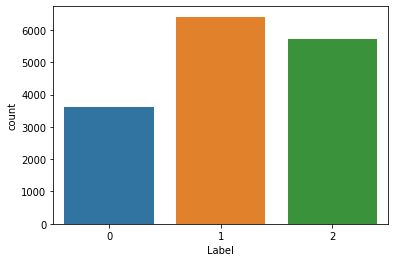

In [5]:
sns.countplot(df['Label'])

In [6]:
df.Label.value_counts(), len(df)

(1    6410
 2    5709
 0    3609
 Name: Label, dtype: int64, 15728)

In [7]:
df=df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','sigmoid'],
            'gamma':['auto','scale'],
            'decision_function_shape':['ovo', 'ovr']

        }  
    },
    
    'decision tree':{
        'model':DecisionTreeClassifier(),
        'params':{
            'max_depth' : [125,500,700,900],
            'max_features' : ["sqrt","log2"],
            'min_samples_split' : [15,55,95],
            'criterion':['entropy']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,25],
            #'weights': ['uniform','distance']
            
        }
    },
    'multinomial naive bayes':{
        'model':MultinomialNB(),
        'params':{
            'alpha':[.10,.25,.40,.75,.90]
        }
    },
    'k nearest neighbors':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors': [3,4,5,6,7],
            'weights': ['uniform','distance'], 
            'algorithm' : ['ball_tree', 'kd_tree', 'brute']

            
        }
    },
    'Stochastic Gradient Descent':{
        'model':SGDClassifier(),
        'params':{
            'loss':['log'],
            'penalty':['l2', 'l1', 'elasticnet'], 
            'alpha':[.0001,.0005,.0009,.0012]

        }
    }
}

In [10]:
scores_function = ['precision_macro','recall_macro','f1','accuracy']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
x_bow = vect.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_bow,df['Label'] , test_size=0.2, random_state=42)

In [ ]:
categories=[0,1,2]

In [ ]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('3 classes BOW ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 



,model,best_params,precision,recall,f1,accuracy
0,svm,"{'C': 10, 'decision_function_shape': 'ovo', 'g...",0.573254,0.570265,0.569966,0.604577
2,logistic_regression,{'C': 1},0.522904,0.514304,0.499110,0.569612
3,multinomial naive bayes,{'alpha': 0.9},0.520778,0.513854,0.501453,0.567069
5,Stochastic Gradient Descent,"{'alpha': 0.0005, 'loss': 'log', 'penalty': 'e...",0.522963,0.505080,0.483893,0.564209
4,k nearest neighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.529521,0.529198,0.528682,0.550540
1,decision tree,"{'criterion': 'entropy', 'max_depth': 500, 'ma...",0.512328,0.510319,0.510384,0.540687


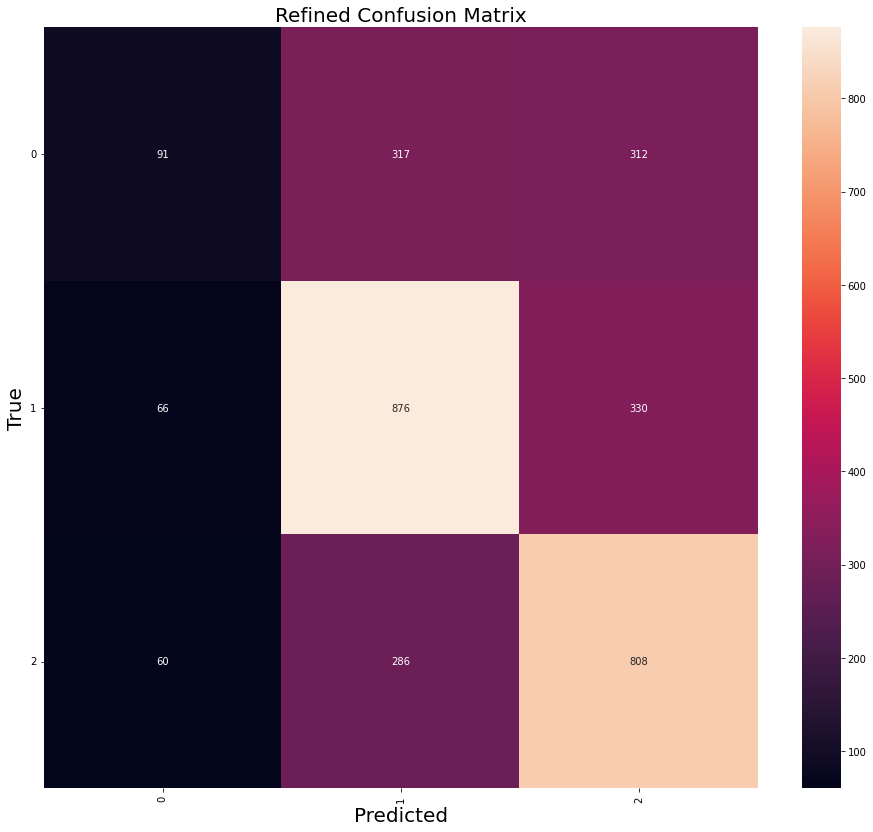

In [ ]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_test, y_pred)


labels = 3

class_names = categories 

fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [ ]:
#TF-IDF unigram
tfidf_unigram = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_unigram= tfidf_unigram.fit_transform(df['Token'])
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_unigram,df['Label'], test_size=0.2, random_state=42)

In [ ]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('3 classes BOW ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


In [ ]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 3
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [11]:
#TF-IDF Bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_bigram = tfidf_bigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_bigram,df['Label'], test_size=0.2, random_state=42)

In [ ]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('3 classes BOW ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


In [ ]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 3
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [ ]:
#TF-IDF Trigram
tfidf_trigram = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
x_tfidf_trigram = tfidf_trigram.fit_transform(df['Token'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_trigram,df['Label'], test_size=0.2, random_state=42)

In [ ]:
scores = []
for model_name, mp in model_params.items():
  for score in scores_function:
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, scoring=score)
    clf.fit(x_train,y_train)
    
  scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'precision':precision_score(y_test,clf.predict(x_test),average='macro'),
            'recall':recall_score(y_test,clf.predict(x_test),average='macro'),
            'f1':f1_score(y_test,clf.predict(x_test),average='macro'),
            'accuracy':accuracy_score(y_test,clf.predict(x_test))
        })
    
df_score = pd.DataFrame(scores,columns=['model','best_params','precision','recall','f1','accuracy'])
df_score.to_excel('3 classes BOW ML parameters.xlsx')
df_score.sort_values(by=['accuracy'],ascending=False) 


In [ ]:
y_pred=clf.best_estimator_.predict(x_test)
y_pred = y_pred.reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 3
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()